### Compute Metric Example Workflow

In this notebook we showcase how a fictional T&E engineer, Jack, could utilize NRTK and the ImageMetric interface in a workflow.

Jack has identified that the quality of images his model will be receiving is likely to degrade due to a variety of natural pertubations beyond what was initially expected. He wants to use NRTK to explore the direct relationship between image quality and model performance.

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import random
import urllib
from collections.abc import Iterable, Iterator, Sequence
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Callable

import maite.protocols.object_detection as od
import numpy as np
import torch
from maite.protocols import ArrayLike
from maite.workflows import evaluate
from matplotlib import pyplot as plt  # type: ignore
from models.datasets import VisDroneDataset
from nrtk_jatic.interop.object_detection.augmentation import JATICDetectionAugmentation
from numpy.typing import NDArray
from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone
from smqtk_detection.interfaces.detect_image_objects import DetectImageObjects
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from nrtk.impls.image_metric.snr_image_metric import SNRImageMetric
from nrtk.impls.perturb_image.generic.cv2.blur import AverageBlurPerturber
from nrtk.impls.perturb_image.generic.PIL.enhance import BrightnessPerturber
from nrtk.impls.perturb_image.generic.skimage.random_noise import PepperNoisePerturber

Jack will be using the maite evaluate functionality to perform his model evaluation. In order to use that, he needs to set up a number of maite compliant objects (Metric, Dataset, and Model). He starts by loading in a portion of the Visdrone Dataset into his maite compiant Dataset object

In [6]:
@dataclass
class ObjectDetectionData:
    """Dataclass for object detection"""

    boxes: ArrayLike
    labels: ArrayLike
    scores: ArrayLike

    def __iter__(self) -> Iterator[tuple[ArrayLike, ArrayLike, ArrayLike]]:
        """Return iterator of ObjectDetectionData"""
        self.n = 0
        return self

    def __next__(self) -> tuple[ArrayLike, ArrayLike, ArrayLike]:
        """Return next ObjectDetectionData in iterator"""
        if self.n < len(self.boxes):
            self.n += 1
            return self.boxes[self.n - 1].astype(np.float32), self.labels[self.n - 1], self.scores[self.n - 1]
        raise StopIteration


DEMO_ROOT = Path.cwd().parent
basic_dataset: od.Dataset = VisDroneDataset(DEMO_ROOT / "examples/data" / "VisDrone2019-DET-test-dev-TINY")

Next Jack defines a metric which he wants to use for a quantitative evaluation of his model. He chooses to use the Mean Average Precision metric implemented in `torchmetrics`, and he wraps that in a class that complies with the maite Metric protocol.

In [7]:
tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=False,
    extended_summary=False,
    average="macro",
)


class WrappedTorchmetricsMetric:
    """MAITE wrapper for torch metric"""

    def __init__(
        self,
        tm_metric: Callable[[list[dict[str, torch.Tensor]], list[dict[str, torch.Tensor]]], dict[str, Any]],
    ) -> None:
        """Initialize wrapped torch metric"""
        self._tm_metric = tm_metric

    # Create utility function to convert ObjectDetectionTarget_impl type to what
    # the type expected by torchmetrics IntersectionOverUnion metric
    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """
        Convert an ObjectDetectionTarget_impl into a dictionary expected internally by
        raw `update` method of raw torchmetrics method
        """
        return {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels),
        }

    def update(self, preds: od.TargetBatchType, targets: od.TargetBatchType) -> None:
        """Update predictions and targets for metric"""
        # Convert to natively-typed from of preds/targets
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        """Compute metric"""
        return self._tm_metric.compute()

    def reset(self) -> None:
        """Reset metric"""
        self._tm_metric.reset()


map_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)

Lastly he loads the centernet model he wants to evaluate and creates a wrapper class for the model that complies with the maite Model protocol

In [8]:
@dataclass
class SMQTKModelMetadata:
    """This is the implementation of ModelMetadata protocol"""

    model_name: str
    provider: str
    task: str
    model_info: dict  # model_info is the user defined metadata


@dataclass
class SMQTKObjectDetectionOutput:
    """Dataclass for SMQTK object detection"""

    boxes: Sequence[NDArray]
    labels: Sequence[NDArray]
    scores: Sequence[NDArray]


def _get_top_label_score(label2score: dict) -> tuple[Any, float]:
    k = list(label2score.keys())
    v = list(label2score.values())
    max_v = max(v)
    return k[v.index(max_v)], max_v


class SMQTKObjectDetector:
    """
    Wraps SMQTK `DetectImageObjects` as MAITE `ObjectDetector`.

    Parameters
    ----------
    smqtk_detector : DetectImageObjects
        The SMQTK bject detector to wrap.
    labels : Sequence[str]
        Labels for classes that object detector can detect.
    model_name: str
        The name of the model, used for model's metadata
    map_output_labels : bool
        Whether wrapper needs to map string outputs from SMQTK detector to integers.
    metadata: SMQTKModelMetadata
        Model metadata
    """

    metadata: SMQTKModelMetadata

    def __init__(
        self,
        smqtk_detector: DetectImageObjects,
        labels: Sequence[str],
        map_output_labels: bool,
        metadata: SMQTKModelMetadata,
    ) -> None:
        """Initialize SMQTKObjectDetector"""
        self.smqtk_detector = smqtk_detector
        self.labels = labels
        self.label2int: dict[str, int] = {label: idx for idx, label in enumerate(labels)}
        self.map_output_labels = map_output_labels
        self.metadata = metadata

    def get_labels(self) -> Sequence[str]:
        """Get labels for model"""
        return self.labels

    def _format_imgs(self, data_seq: Sequence[ArrayLike]) -> Iterable[NDArray]:
        """Reformat imgs"""
        arr_iter: Iterable[NDArray] = []
        for img in data_seq:
            if isinstance(img, torch.Tensor) and len(img.shape) == 3:
                arr_iter.append(img.detach().cpu().numpy().transpose([1, 2, 0]))
            elif isinstance(img, np.ndarray) and len(img.shape) == 3:
                if img.shape[0] != 3:
                    img = img.transpose([2, 0, 1])
                arr_iter.append(img.transpose([1, 2, 0]))
            else:
                raise Exception(f"Unable to handle sequence item of type: {type(img)}")

        return arr_iter

    def __call__(self, data: Sequence[ArrayLike]) -> Sequence[ObjectDetectionData]:
        """
        SMQTK DetectImageObjects.detect_objects
        - input: Iterable[ndarray]
        - output: Iterable[Iterable[Tuple[AxisAlignedBoundingBox, Dict[Hashable, float]]]]
        """
        # reformat data as sequence first if necessary
        # tensor bridging
        if isinstance(data, np.ndarray):
            data_seq = list(data) if len(data.shape) == 4 else [data]
        elif isinstance(data, Sequence):
            # already a sequence
            data_seq = data  # convert to Iterable[ndarray]

        arr_iter = self._format_imgs(data_seq)
        smqtk_output = self.smqtk_detector.detect_objects(arr_iter)
        # assume num detections for image i is nd_i
        # sequence of shape-(nd_i, 4) bounding box arrays

        # sequence of shape-(nd_i,) arrays of predicted class associated with each bounding box

        # sequence of shape-(nd_i,) arrays of score for predicted class associated with each bounding box

        # bounding boxes, top label for each box, top score for each box for *single* image
        boxes = []
        labels = []
        scores = []

        for bbox, label2score in smqtk_output[0]:
            flatten_box = np.hstack([bbox.min_vertex, bbox.max_vertex])
            boxes.append(flatten_box)

            top_label, top_score = _get_top_label_score(label2score)
            if self.map_output_labels:
                top_label = self.label2int[top_label]

            labels.append(top_label)
            scores.append(top_score)

        return [SMQTKObjectDetectionOutput(boxes=boxes, labels=labels, scores=scores)]


# download weights if necessary
model_dir = DEMO_ROOT / "examples" / "models"

model_file = Path(model_dir) / "centernet-resnet50.pth"
provider = "Kitware: github.com/SMQTK-Detection"

if not model_file.is_file():
    print(f"Downloading CenterNet model checkpoint to: {model_file}")
    urllib.request.urlretrieve(  # type: ignore
        "https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download",
        model_file,
    )

centernet_detector = CenterNetVisdrone(
    arch="resnet50",
    model_file=str(model_file),
    max_dets=500,
    use_cuda=False,
    batch_size=1,
    num_workers=1,
)

metadata = SMQTKModelMetadata(
    provider=provider,
    model_name="tph-yolov5",
    task="object-detection",
    model_info={
        "model_file": str(model_file.relative_to(model_file.parents[3])),
        "arch": "resnet50",
        "max_dets": 500,
    },
)


jatic_detector = SMQTKObjectDetector(
    centernet_detector,
    VisDroneDataset.classes,
    map_output_labels=True,
    metadata=metadata,
)

After creating the appropriate set of maite compliant object, Jack is ready to perform the maite evaluation across a number of generic perturbations. However in addition to the raw model performance for a given set of pertubations, Jack wants a quantifiable measure of how much each pertubation changes the image in order to generalize accross different pertubations. In order to quantify how much a given pertubation modifies the image, he decides to use the Signal to Noise Ratio implementation of the ImageMetric class.

As the final set up for his experiments, Jack sets the random seeds for consistency and defines the image quality metric he wants to use

In [9]:
img_quality_metric = SNRImageMetric()

random.seed(42)
np_random = np.random.default_rng(42)
torch.manual_seed(42)

The first experiment Jack wants to run is using the PepperNoisePerturber that adds black noise into the image. He evaluates the model across an incresing degree of noise in the image keeping track of the model performance metric and the image quality metric for each pertubation parameter.

In [10]:
pepper_noise_img_quality_metrics = []
pepper_noise_performance = []
basic_dataset.set_reshape(False)

for amount in [i * 0.05 for i in range(15)]:
    perturber = PepperNoisePerturber(amount=amount)
    augmentation = JATICDetectionAugmentation(perturber)
    results, _, _ = evaluate(model=jatic_detector, metric=map_metric, dataset=basic_dataset, augmentation=augmentation)
    pepper_noise_performance.append(results["map"])
    avg_quality = 0
    for batch in basic_dataset:
        aug_img, _, _ = augmentation([[component] for component in batch])
        aug_img = np.transpose(aug_img[0], (1, 2, 0))
        avg_quality += img_quality_metric.compute(aug_img)
    pepper_noise_img_quality_metrics.append(avg_quality / len(basic_dataset))

0it [00:00, ?it/s]/tmp/ipykernel_427798/624054600.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  "boxes": torch.as_tensor(target.boxes),
/home/local/KHQ/alexander.lynch/anaconda3/envs/nrtk-jatic/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
11it [00:33,  3.03s/it]
11it [00:27,  2.50s/it]
11it [00:25,  2.36s/it]
11it [00:26,  2.

After collecting all of the metrics, Jack first wants to confirm that there is a relationship between the image metric, and the amount of noise being applied to the image. He is able to see that as the noise in the image increases, the signal to noise metric decreases. With this knowledge he then looks at the relationship between the image metric and the model performance. Now he finds that the model performance increases with the signal to noise image metric. If his baseline performance for this model is 0.15, then he knows that he needs a signal to noise ratio of at least 2.0

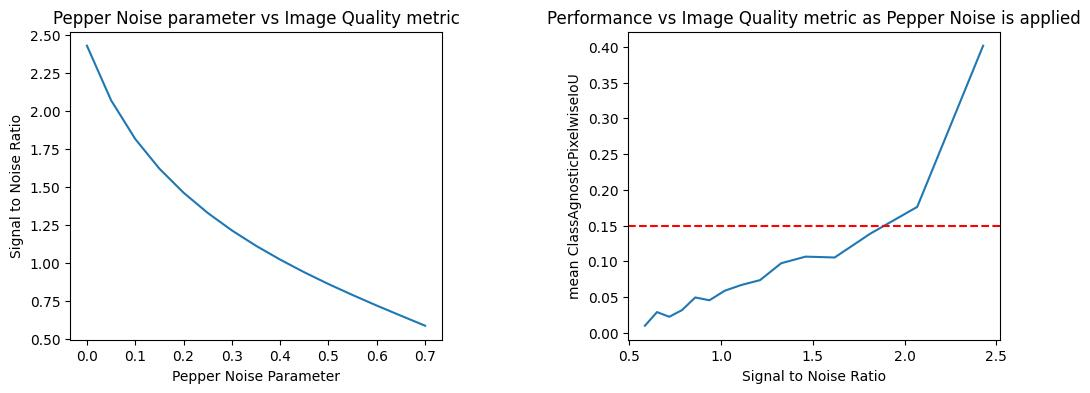

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

ax1.plot([i * 0.05 for i in range(15)], pepper_noise_img_quality_metrics)
ax1.set_title("Pepper Noise parameter vs Image Quality metric")
ax1.set_xlabel("Pepper Noise Parameter")
ax1.set_ylabel("Signal to Noise Ratio")

ax2.plot(pepper_noise_img_quality_metrics, pepper_noise_performance)
ax2.axhline(y=0.15, color="red", linestyle="--")
ax2.set_title("Performance vs Image Quality metric as Pepper Noise is applied")
ax2.set_xlabel("Signal to Noise Ratio")
ax2.set_ylabel("mean ClassAgnosticPixelwiseIoU")

plt.subplots_adjust(wspace=0.5)  # Increase wspace to add more horizontal space

Now Jack wants to perform the same experiment but adding in a brightness parameterinstead of pepper noise.

In [12]:
brightness_img_quality_metrics = []
brightness_performance = []
basic_dataset.set_reshape(True)
for factor in [i * 0.1 for i in range(1, 16)]:
    perturber = BrightnessPerturber(factor=factor)
    augmentation = JATICDetectionAugmentation(perturber)
    results, _, _ = evaluate(model=jatic_detector, metric=map_metric, dataset=basic_dataset, augmentation=augmentation)
    brightness_performance.append(results["map"])
    avg_quality = 0
    for batch in basic_dataset:
        aug_img, _, _ = augmentation([[component] for component in batch])
        aug_img = np.array(aug_img[0])
        avg_quality += img_quality_metric.compute(aug_img)
    brightness_img_quality_metrics.append(avg_quality / len(basic_dataset))

0it [00:00, ?it/s]/home/local/KHQ/alexander.lynch/anaconda3/envs/nrtk-jatic/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
11it [00:26,  2.38s/it]
11it [00:25,  2.32s/it]
11it [00:28,  2.56s/it]
11it [00:29,  2.66s/it]
11it [00:27,  2.47s/it]
11it [00:27,  2.51s/it]
11it [00:26,  2.45s/it]
11it [00:26,  2.45s/it]
11it [00:26,  2.43s/it]
11it [00:29,  2.66s/it]
11it [00:30,  2.76s/it]
11it [00:30,  2.78s/it]
11it [00:31,  2.83s/it]
11it [00:30,  2.81s/it]
11it [00:30,  2.78s/it]


After anaylysing this set of results, Jack sees that the brightness parameter has mush less of an impact on the Signal to Noise Ratio. The Image metric isn't monotonically increasing like the previous experiment however, so Jack notes the behaviour when the imagemetric is between 2.40 and 2.45

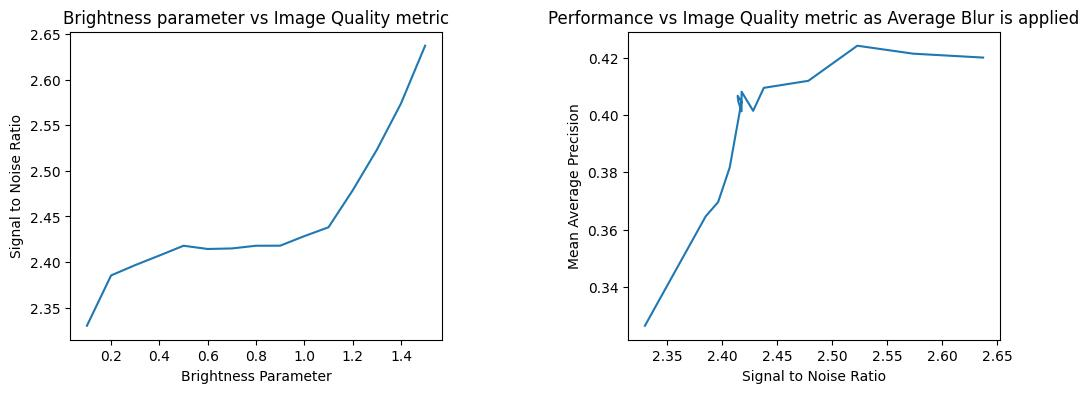

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

ax1.plot([i * 0.1 for i in range(1, 16)], brightness_img_quality_metrics)
ax1.set_title("Brightness parameter vs Image Quality metric")
ax1.set_xlabel("Brightness Parameter")
ax1.set_ylabel("Signal to Noise Ratio")

ax2.plot(brightness_img_quality_metrics, brightness_performance)
ax2.set_title("Performance vs Image Quality metric as Average Blur is applied")
ax2.set_xlabel("Signal to Noise Ratio")
ax2.set_ylabel("Mean Average Precision")

plt.subplots_adjust(wspace=0.5)  # Increase wspace to add more horizontal space

Finally Jack wants to perform the experiment with a blur pertubation\.

In [14]:
blur_img_quality_metrics = []
blur_performance = []
basic_dataset.set_reshape(True)
for ksize in range(151, 0, -10):
    perturber = AverageBlurPerturber(ksize=ksize)
    augmentation = JATICDetectionAugmentation(perturber)
    results, _, _ = evaluate(model=jatic_detector, metric=map_metric, dataset=basic_dataset, augmentation=augmentation)
    blur_performance.append(results["map"])
    avg_quality = 0
    for batch in basic_dataset:
        aug_img, _, _ = augmentation([[component] for component in batch])
        aug_img = np.array(aug_img[0])
        avg_quality += img_quality_metric.compute(aug_img)
    blur_img_quality_metrics.append(avg_quality / len(basic_dataset))

0it [00:00, ?it/s]/home/local/KHQ/alexander.lynch/anaconda3/envs/nrtk-jatic/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
11it [00:30,  2.76s/it]
11it [00:30,  2.75s/it]
11it [00:31,  2.84s/it]
11it [00:30,  2.80s/it]
11it [00:30,  2.74s/it]
11it [00:30,  2.78s/it]
11it [00:30,  2.76s/it]
11it [00:30,  2.78s/it]
11it [00:30,  2.78s/it]
11it [00:29,  2.71s/it]
11it [00:30,  2.76s/it]
11it [00:30,  2.80s/it]
11it [00:30,  2.75s/it]
11it [00:30,  2.76s/it]
11it [00:30,  2.76s/it]
11it [00:30,  2.79s/it]


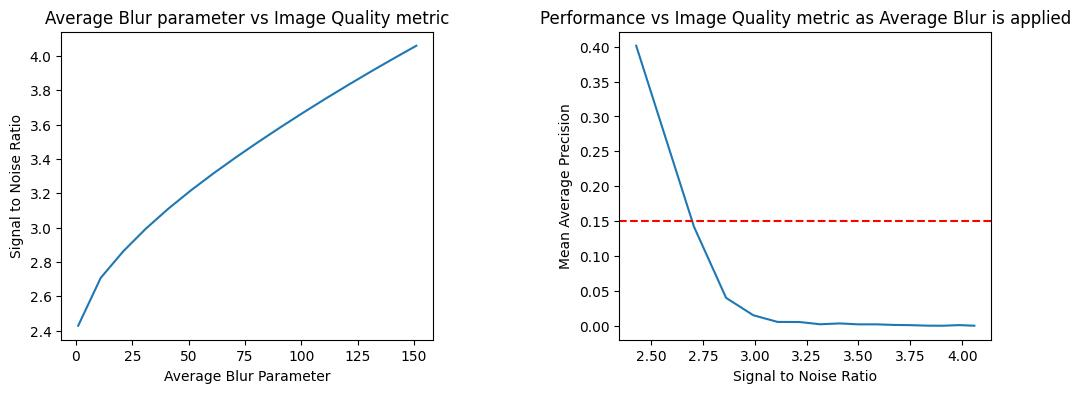

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

ax1.plot(list(range(151, 0, -10)), blur_img_quality_metrics)
ax1.set_title("Average Blur parameter vs Image Quality metric")
ax1.set_xlabel("Average Blur Parameter")
ax1.set_ylabel("Signal to Noise Ratio")

ax2.plot(blur_img_quality_metrics, blur_performance)
ax2.axhline(y=0.15, color="red", linestyle="--")
ax2.set_title("Performance vs Image Quality metric as Average Blur is applied")
ax2.set_xlabel("Signal to Noise Ratio")
ax2.set_ylabel("Mean Average Precision")

plt.subplots_adjust(wspace=0.5)  # Increase wspace to add more horizontal space

Now that Jack has performed his experiments on three different pertubations, he wants to compare the results in order to find out what range of signal to noise ratio equates to acceptable performance of his model

Text(0, 0.5, 'Mean Average Precision')

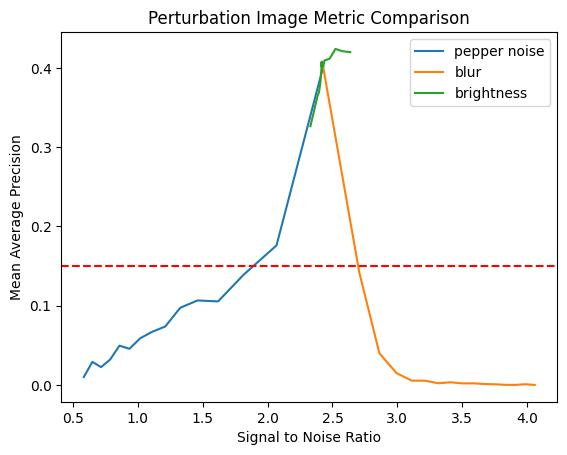

In [18]:
plt.plot(pepper_noise_img_quality_metrics, pepper_noise_performance, label="pepper noise")
plt.plot(blur_img_quality_metrics, blur_performance, label="blur")
plt.plot(brightness_img_quality_metrics, brightness_performance, label="brightness")
plt.axhline(y=0.15, color="red", linestyle="--")
plt.legend()
plt.title("Perturbation Image Metric Comparison")
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Mean Average Precision")

After analysing the performance vs image metric graphs, Jack concludes that when the image metric falls below 2.0 or above 2.7, the model performance drops past the acceptable level. He can then advise specific monitoring of the image quality metric that is collected to identify when the model is likely to suffer in quality.